In [1]:
import numpy as np
import matplotlib.pyplot as plt

# install some packages that we're going to use in this tutorial
#!pip install git+https://github.com/changhoonhahn/provabgs
#!pip install corner
#!pip install sbi

import torch
from sbi import utils as Ut
from sbi import inference as Inference
import corner

In [2]:
import pickle
from tqdm import tqdm

We load our observations ( latent vectors - low dimension representations of spectrums ) and our properties ( time of percentiles of stellar mass )

In [3]:
latents_batch=np.load('./input_dataset/latents.npy',allow_pickle=True)
percentiles=np.load('./input_dataset/percentiles.npy',allow_pickle=True)

In [4]:
latents=np.zeros((10000,16))
batch_size=512

for j in range(len(latents_batch)):
    for i,x in enumerate(latents_batch[j]):
        latents[batch_size*j+i,:]=x
        
print(np.shape(latents))
print(np.shape(percentiles))

(10000, 16)
(10000, 9)


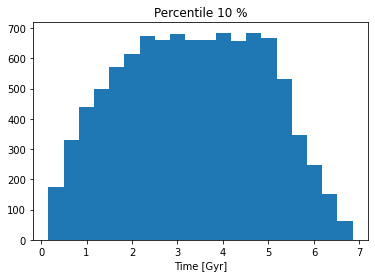

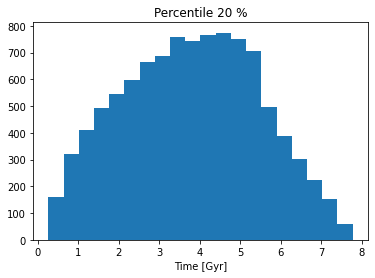

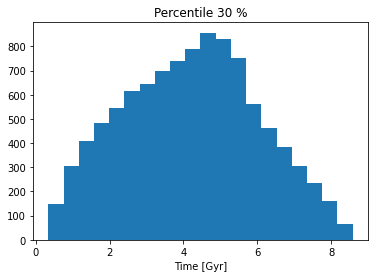

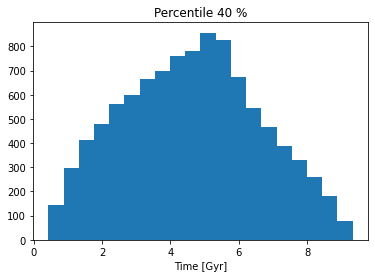

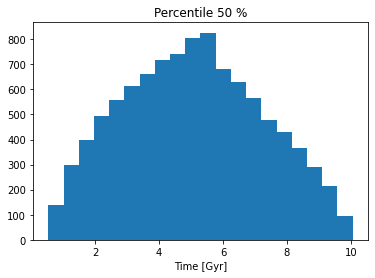

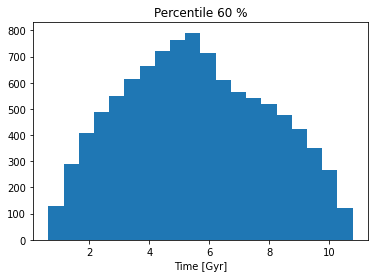

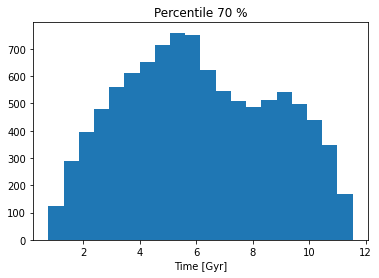

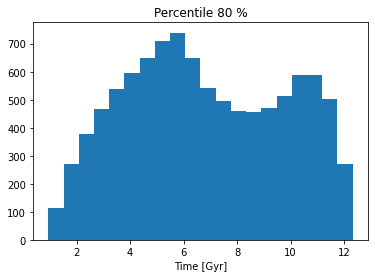

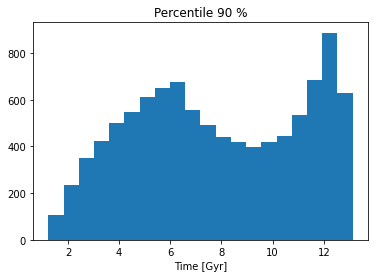

"for i in range(16):\n    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))\n#plt.legend()\nplt.title('latent components ')\nplt.show()"

In [31]:
#percentiles well distributed ¿? 
for i in range(9):
    plt.hist(percentiles[:,i],bins=20)
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.xlabel('Time [Gyr]')
    plt.show()

"""for j in np.arange(0,10000):
    plt.plot(percentiles[j,:],np.arange(10,100,10),'.-',label='index '+str(j),color='b')
plt.title('Real percentiles')
plt.show()"""

"""for j in np.arange(9000,10000,100):
    plt.plot(percentiles[j,:],np.arange(10,100,10),'.-',label='index '+str(j))
plt.title('Real percentiles')
plt.show()"""

#latent components not
"""for i in range(16):
    plt.hist(latents[:,i],bins=40,label='l'+str(i+1))
#plt.legend()
plt.title('latent components ')
plt.show()"""

SBI requires setting a parameter range for when it later samples the posterior. 
Note that the package refers to this as the "prior"; however, in our case we're 
just going to set it from our dataset. This is because our (theta, X) samples are
already drawn from the prior, so it's already built into our training data. 

In [7]:
#observations - x
x=np.copy(latents)

#properties - x
theta=np.copy(percentiles)

print(np.shape(np.min(theta,axis=0)))

lower_bounds = torch.tensor(np.min(theta,axis=0)-1) 
upper_bounds = torch.tensor(np.max(theta,axis=0)+1)

bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

(9,)


Prior plot

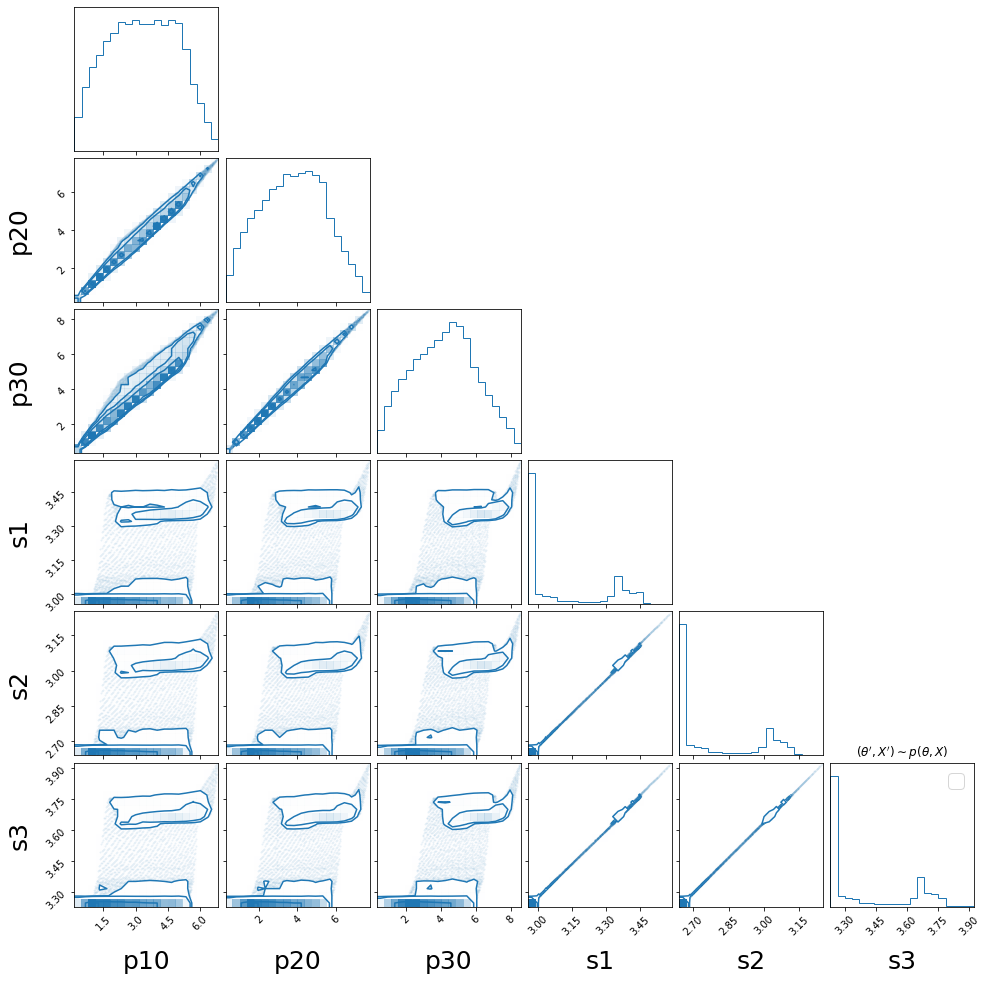

In [8]:
lx=['s'+str(i) for i in range(1,17)][:3]   #label for latent components
lt=['p'+str(i*10) for i in range(1,10)][:3] #label for percentiles

fig = corner.corner(np.concatenate([theta[:,:3], x[:,:3]], axis=1), 
                labels=np.concatenate([lt,lx]),
                label_kwargs={'fontsize': 25},
                color='C0')#, ranges=[(np.min(theta[:,0])-1,np.max(theta[:,0])+1),(np.min(theta[:,1])-1,np.max(theta[:,1])+1),(np.min(theta[:,2])-1,np.max(theta[:,2])+1),(np.min(x[:,0])-1,np.max(x[:,0])+1),(np.min(x[:,1])-1,np.max(x[:,1])+1),(np.min(x[:,2])-1,np.max(x[:,2])+1)])


plt.title(r"$(\theta', X')\sim p(\theta, X)$")
plt.legend(fontsize=20)
plt.show()

#we see the latent components follow a bimodal distribution

Building and training the model

In [9]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train()
qphi = anpe.build_posterior(p_theta_x_est)

 Neural network successfully converged after 82 epochs.

Predict posteriors given observations and corner plots (observations are noisy input examples)

j:  5185
j:  3724
j:  8631
j:  9529
j:  891


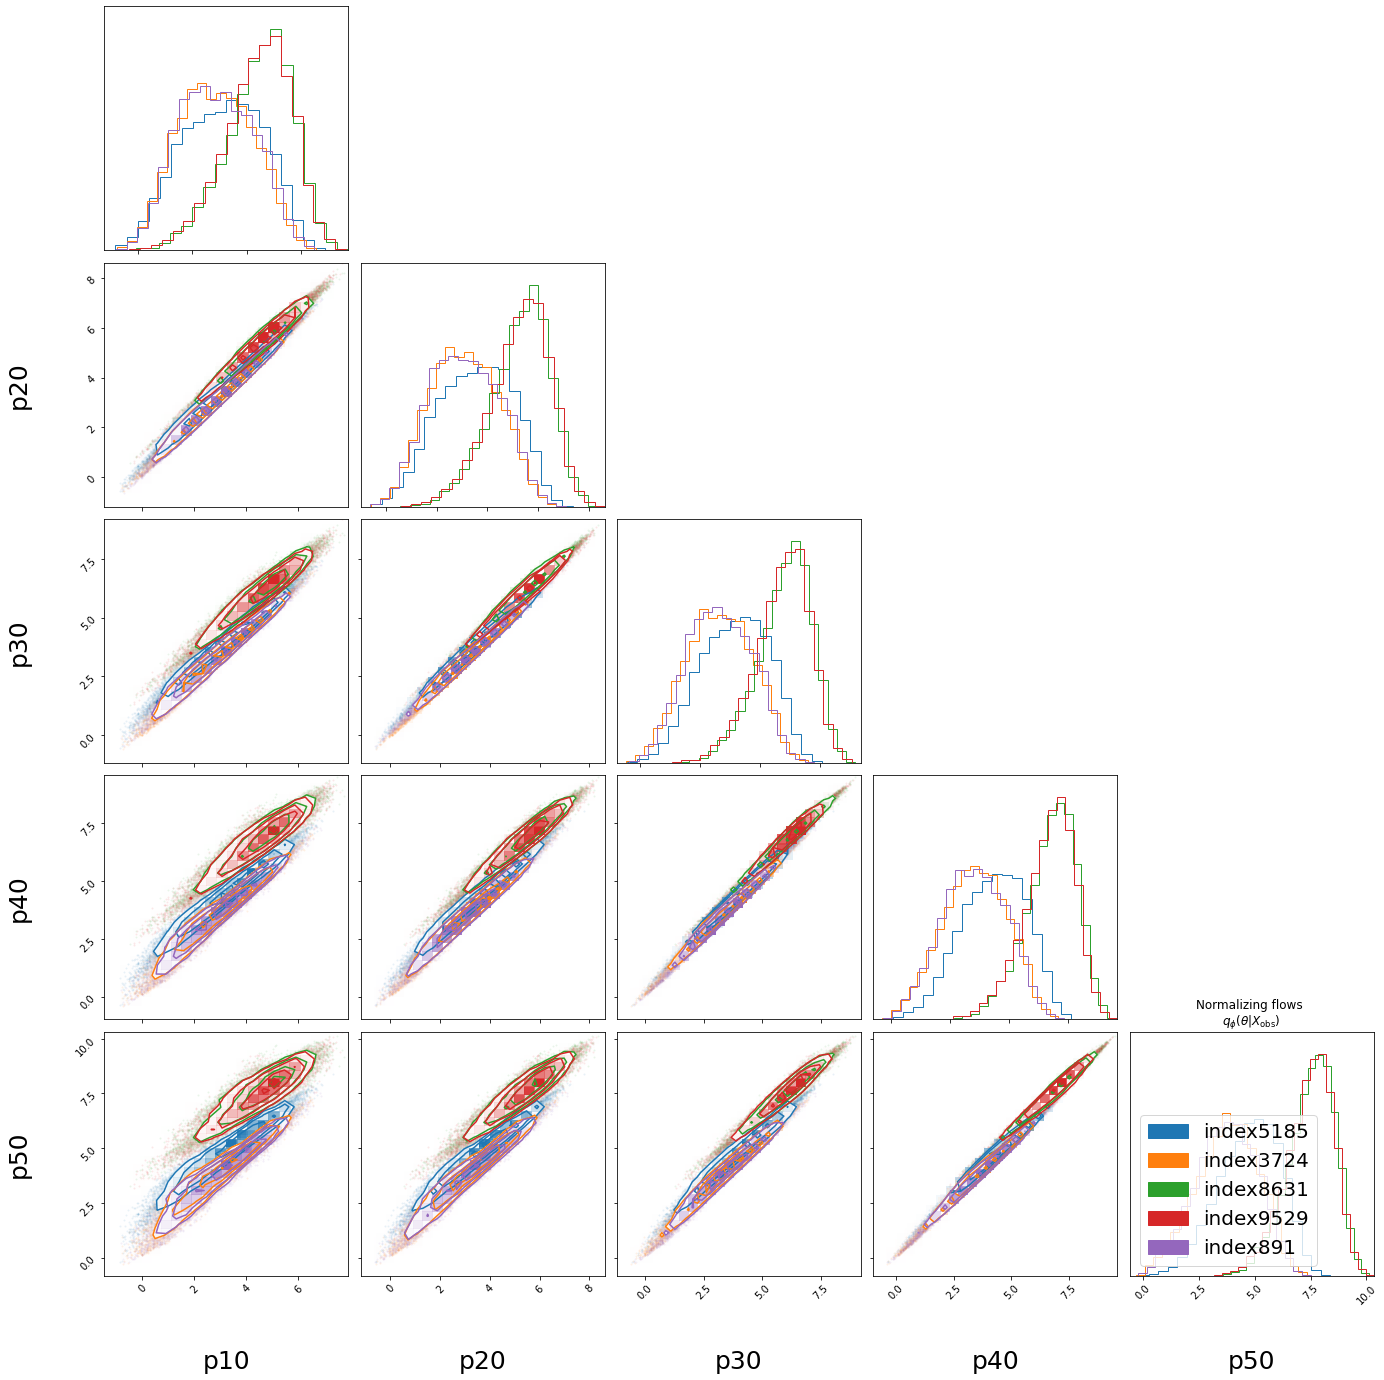

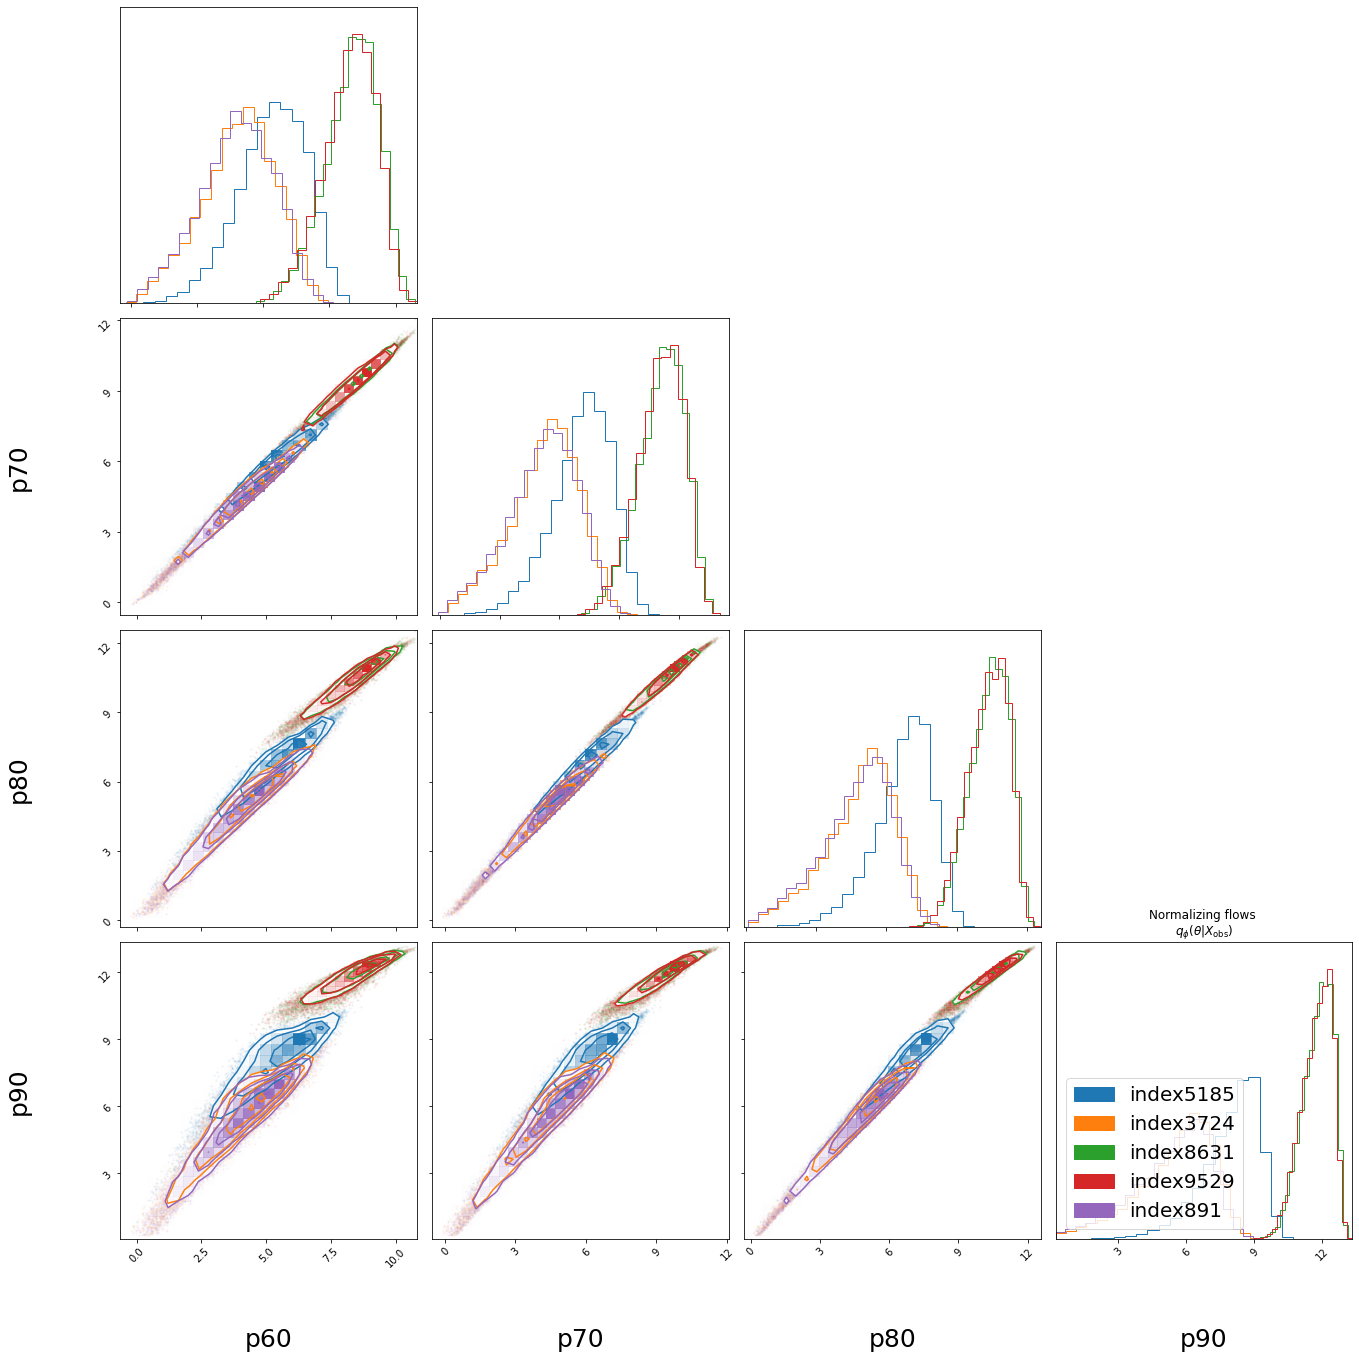

In [45]:
#examples

random_list=np.random.randint(0,10000,5)

fig=plt.figure(figsize=(20,20))

for k,j in enumerate(random_list):
    print('j: ',j)
    Xobs=x[j,:]+np.ones(16)*0.1*np.random.normal(0.0, 0.1) #like the first obs with noise
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))

    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)][:5] #label for percentiles

    #we plot the first 5 percentiles
    _ = corner.corner(posterior_samples[:,:5], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(j))
    
plt.legend(loc='lower left', fontsize=20)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$')
plt.show()


fig=plt.figure(figsize=(20,20))

for k,j in enumerate(random_list):
    Xobs=x[j,:]+np.ones(16)*0.1*np.random.normal(0.0, 0.1) #like the first obs with noise
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))

    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)][5:] #label for percentiles

    #we plot the last 4 percentiles
    _ = corner.corner(posterior_samples[:,5:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(j))
    
plt.legend(loc='lower left', fontsize=20)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$')
plt.show()

Real percentiles and predicted posteriors

7.2007694
6.038506
7.4179907
5.891283
7.4934654
8.722619
10.7634325
11.786417


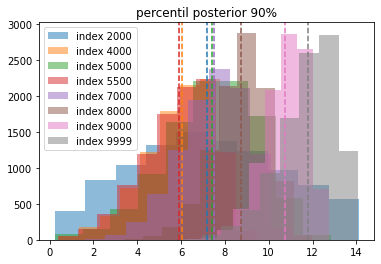

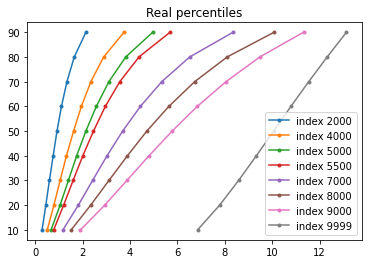

In [76]:
#difference between different galaxies
colors=['C0','C1','C2','C3','C4','C5','C6','C7']


def plot_percentile_distribution(i,index_list=[2000,4000,5000,5500,7000,8000,9000,9999],mean=False,real_plot=False):
    for k,j in enumerate(index_list):
        Xobs=x[j,:]+np.ones(16)*np.random.normal(0, 0.5) #like the first obs with noise
        posterior_samples= np.array(qphi.sample((10000,), 
                                            x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                        show_progress_bars=False).detach().to('cpu'))

        plt.hist(posterior_samples[:,i-1],alpha=0.5,color=colors[k],label='index '+str(j))
        if mean:
            plt.axvline(np.mean(posterior_samples[:,i-1]),ls='--',color=colors[k])
            
    plt.title('percentil posterior ' +str(i*10)+'%')
    plt.legend()
    plt.show()
    
    if real_plot:
        for k,j in enumerate(index_list):
            plt.plot(percentiles[j,:],np.arange(10,100,10),'.-',color=colors[k],label='index '+str(j))
        plt.title('Real percentiles')
        plt.legend()
        plt.show()
        
    
#plot_percentile_distribution(1,mean=True)
#plot_percentile_distribution(5,mean=True)
plot_percentile_distribution(9,mean=True,real_plot=True)

We want to test with new data, never seen by the network (not just noise), we shuffle our dataset and keep the last 1000 samples for testing (train with the first 9000 samples)

In [7]:
#training with the first 9000 elements of the dataset (previously shuffled) - takes longer
index_sh=np.arange(10000)
np.random.shuffle(index_sh)
print(index_sh)

x=latents[index_sh[:9000],:]
theta=percentiles[index_sh[:9000],:]

#cero,14, uniforme
lower_bounds = torch.tensor(np.min(theta,axis=0)-1) 
upper_bounds = torch.tensor(np.max(theta,axis=0)+1)
bounds = Ut.BoxUniform(low=lower_bounds, high=upper_bounds, device='cpu')

[4631 6046 3778 ... 3518 6306  976]


In [83]:
nhidden = 128 
nblocks = 5
maf_model = Ut.posterior_nn('maf', hidden_features=nhidden, num_transforms=nblocks)

anpe = Inference.SNPE(prior=bounds,
                      density_estimator=maf_model,
                      device='cpu')

#anpe, amortized neural posterior estimation
anpe.append_simulations(
            torch.as_tensor(theta.astype(np.float32)).to('cpu'),
            torch.as_tensor(x.astype(np.float32)).to('cpu'))  

# estimate p(theta|X), the posterior
p_theta_x_est = anpe.train()
qphi = anpe.build_posterior(p_theta_x_est)

[2311 6798 8126 ... 7402  482 8645]
 Neural network successfully converged after 162 epochs.

Save posterior or load it 

In [5]:
file="./my_posterior.pkl"

"""with open(file, "wb") as handle:
    pickle.dump(qphi, handle)

handle.close()
np.save('index_sh.npy',index_sh)"""


file = open(file, 'rb')
qphi = pickle.load(file)
file.close()

Again we create a function to see real vs predicted percentiles (intead of plotting all the distribution for the posteriors, we plot the mean and the interval of confidence: sigma, 2sigma...)

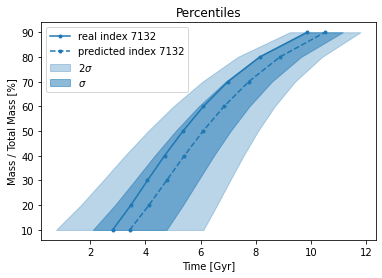

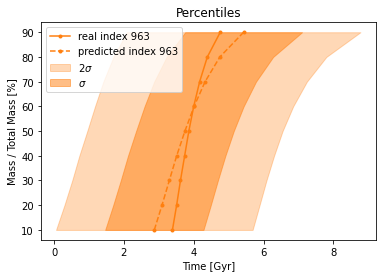

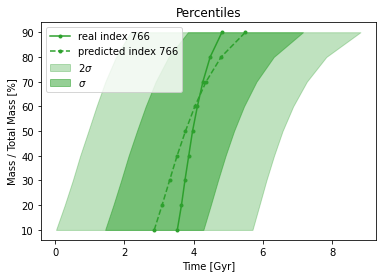

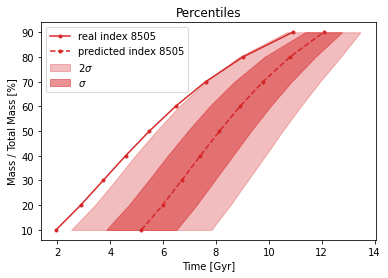

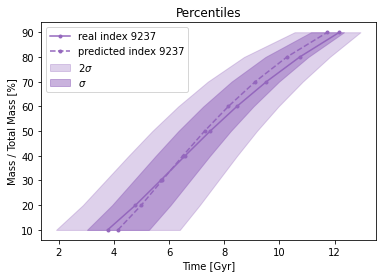

In [44]:


def plot_percentile_distribution(i,index_list=np.random.randint(9000,10000,5),mean=False,real_plot=False):
    
    if i==None:
        for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))
                
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='real index '+str(index_sh[j]))
                plt.plot(np.mean(posterior_samples,axis=0),np.arange(10,100,10),'.--',color='C'+str(k),label='predicted index '+str(index_sh[j]))
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+2*np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-2*np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles')
                plt.legend()
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                plt.show()

        
    else:
         for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                Xobs=latents[index_sh[j],:]
                posterior_samples= np.array(qphi.sample((10000,), 
                                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                                        show_progress_bars=False).detach().to('cpu'))

                plt.hist(posterior_samples[:,i-1],alpha=0.5,color='C'+str(k),label='index '+str(index_sh[j]))

                if mean:
                    plt.axvline(np.mean(posterior_samples[:,i-1]),ls='--',color='C'+str(k))
                    plt.axvline(percentiles[index_sh[j],i-1],ls='-',color='C'+str(k))
         plt.title('percentil posterior ' +str(i*10)+'%')
         #plt.legend()
         plt.xlabel('Time [Gyr]')
         plt.show()
            
         if real_plot:
            for k,j in enumerate(index_list):
                #if index_sh[j]>5000:
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='index '+str(index_sh[j]))
            plt.title('Real percentiles')
            plt.xlabel('Time [Gyr]')
            plt.ylabel('Mass / Total Mass [%]')
            #plt.legend()
            plt.show()
    

    
#plot_percentile_distribution(1,mean=True)
#plot_percentile_distribution(5,mean=True)
#plot_percentile_distribution(9,mean=True,real_plot=True)
plot_percentile_distribution(None)

In [66]:
#let's see which percentage of the samples has all the predictions between sigma and between 2sigma

n_evaluations=1000
n_samples=1000
index_list=np.arange(9000,10000)#np.random.randint(9000,10000,n_evaluations)

stds=[]
means=[]
for k,j in tqdm(enumerate(index_list)):
    Xobs=latents[index_sh[j],:]
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))
    stds.append(np.std(posterior_samples,axis=0))
    means.append(np.mean(posterior_samples,axis=0))



1000it [05:11,  3.21it/s]


54.0 %


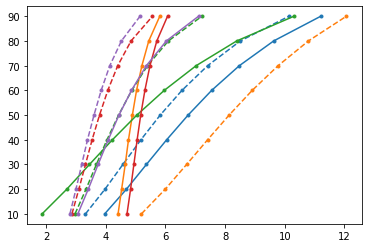

In [69]:
#fraction of galaxies with at least 1 percentil with error outside the 1sigma interval

stds=np.array(stds)
means=np.array(means)

indexes=[]
for k,j in enumerate(index_list):
    for i in range(9):
        if stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print(len(indexes)/n_evaluations * 100, '%')

for k,j in enumerate(indexes[:5]):
 plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='Index '+str(index_sh[j]))
 plt.plot(means[k,:],np.arange(10,100,10),'.--',color='C'+str(k))
            

5.2 %


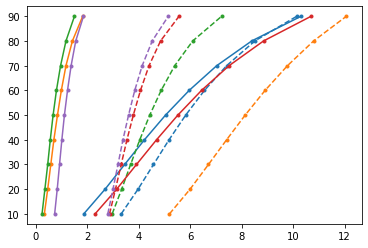

In [68]:
#fraction of galaxies with at least 1 percentil with error outside the 2sigma interval

indexes=[]
for k,j in enumerate(index_list):
    for i in range(9):
        if 2*stds[k,i]<(np.abs(means[k,i]-percentiles[index_sh[j],i])):
            indexes.append(j)
            break

print(len(indexes)/n_evaluations * 100, '%')

for k,j in enumerate(indexes[:5]):
 plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='Index '+str(index_sh[j]))
 plt.plot(means[k,:],np.arange(10,100,10),'.--',color='C'+str(k))
 

In [72]:
#the same but averaged between all percentiles

#sigma
indexes=[]
for k,j in enumerate(index_list):
        if np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)

print(len(indexes)/n_evaluations * 100, '%')

#2sigma
indexes=[]
for k,j in enumerate(index_list):
        if 2*np.mean(stds[k,:])<np.mean(np.abs(means[k,:]-percentiles[index_sh[j],:])):
            indexes.append(j)

print(len(indexes)/n_evaluations * 100, '%')



32.5 %
3.4000000000000004 %


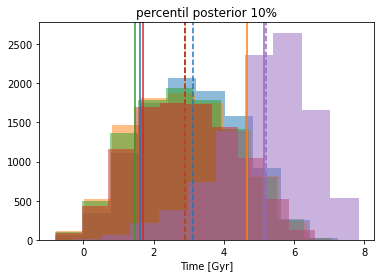

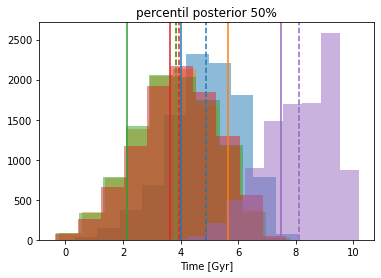

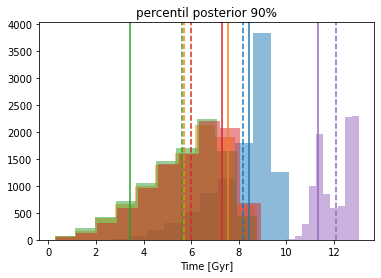

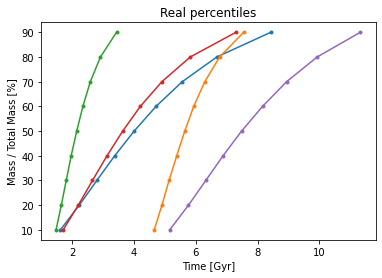

In [43]:
index_list=np.random.randint(9000,10000,5)
plot_percentile_distribution(1,index_list,mean=True)
plot_percentile_distribution(5,index_list,mean=True)
plot_percentile_distribution(9,index_list,mean=True,real_plot=True)

Corner plot of posteriors given new observations (similar but never seen by the model first)

index:  7728
index:  1898
index:  2458
index:  3164
index:  968


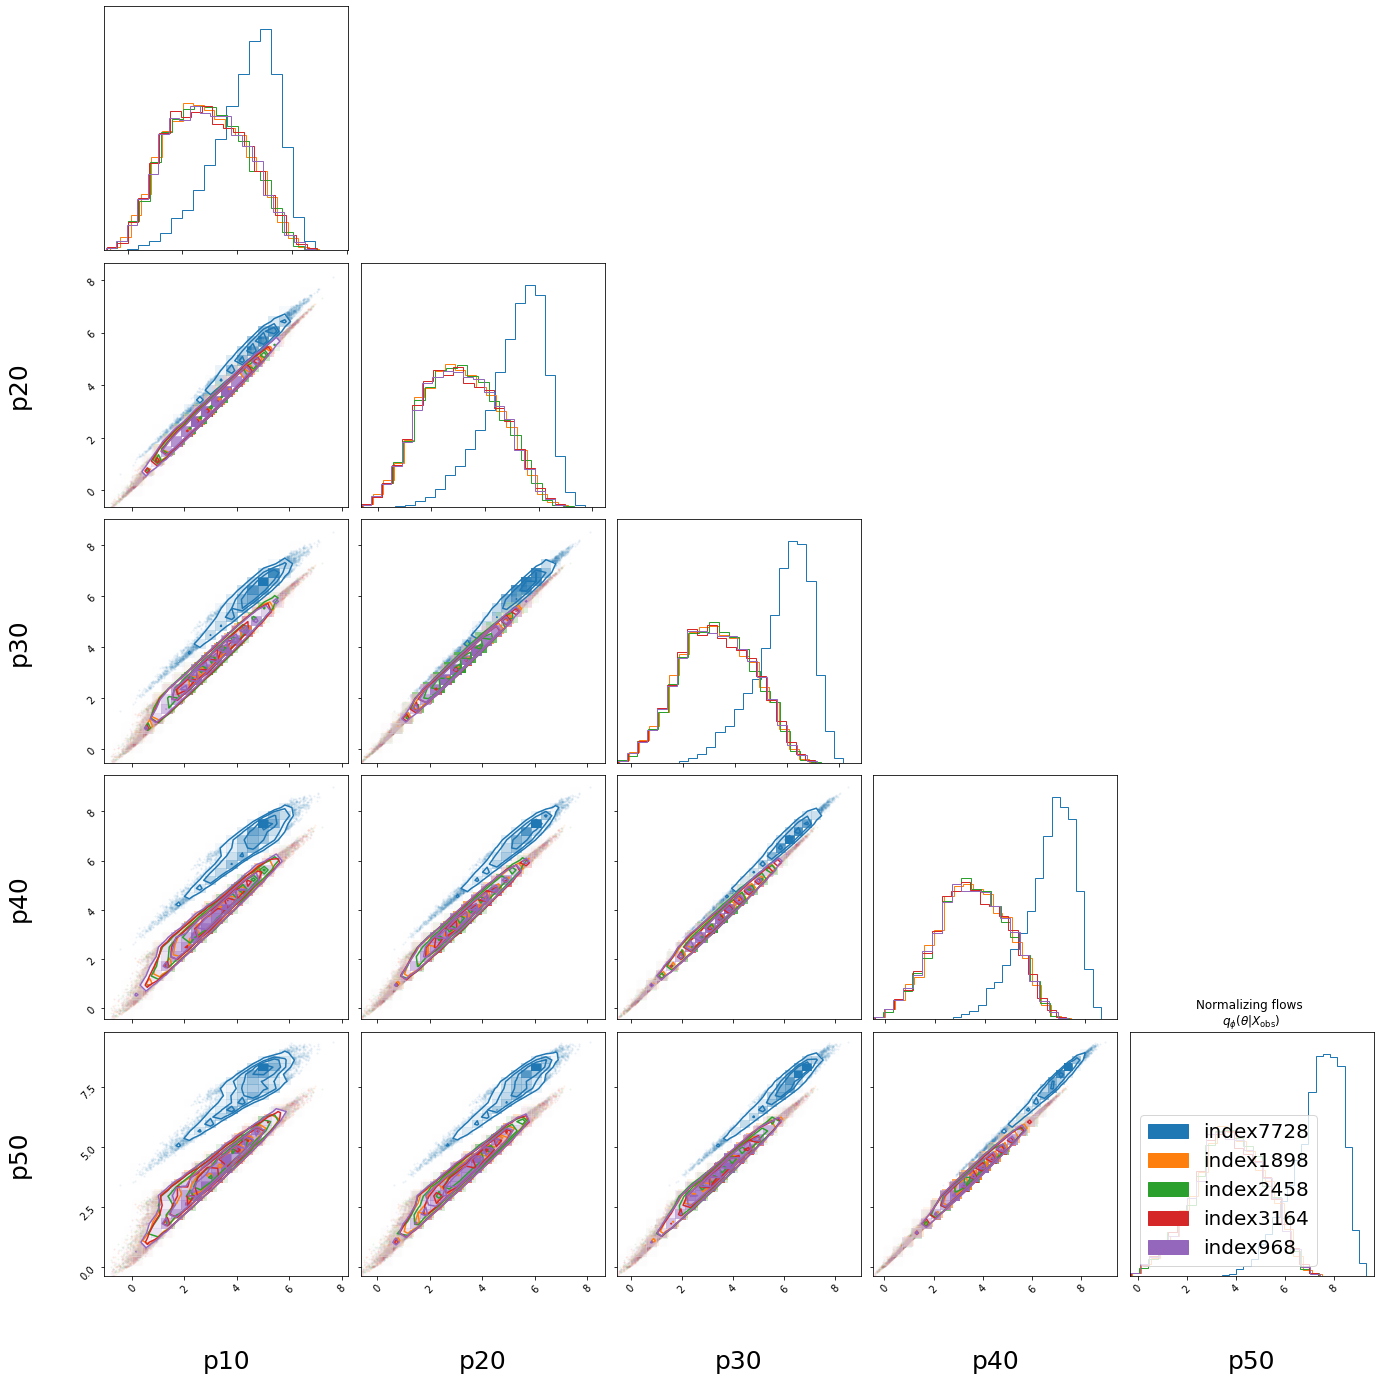

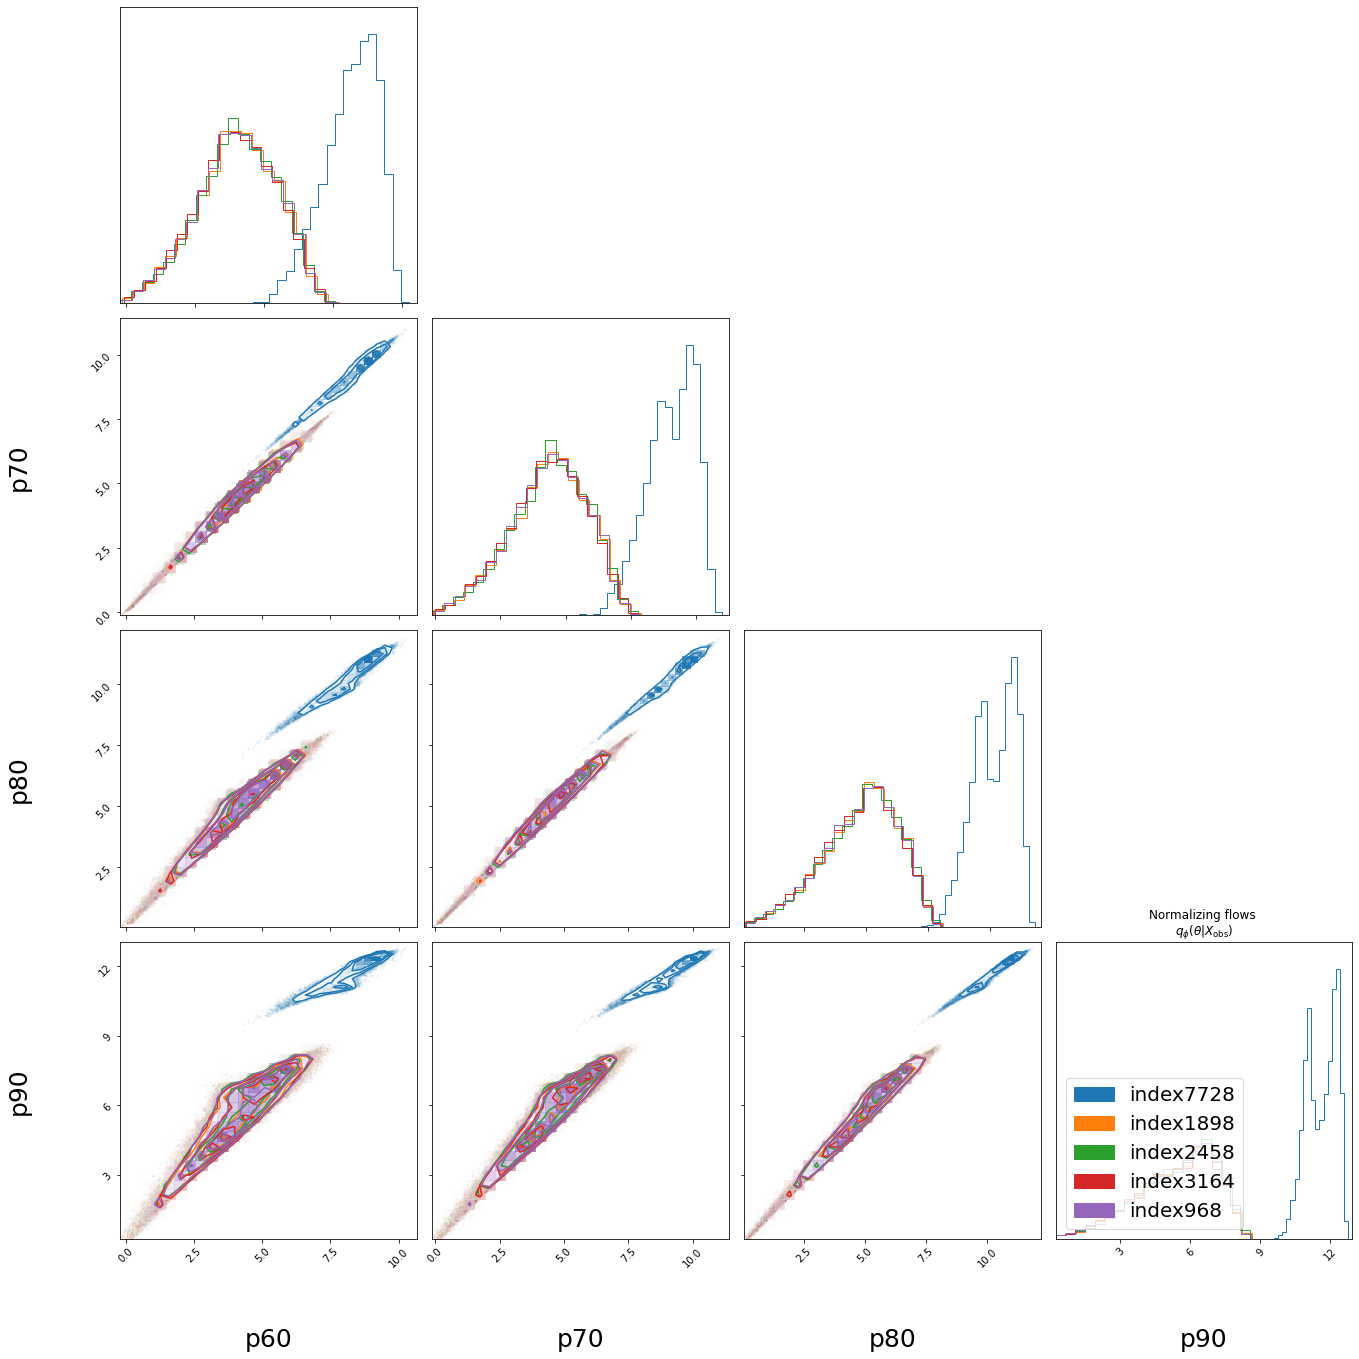

In [117]:
#examples

random_list=np.random.randint(9000,10000,10)

fig=plt.figure(figsize=(20,20))

for k,j in enumerate(random_list):
    print('index: ',index_sh[j])
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))

    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)][:5] #label for percentiles

    #we plot the first 5 percentiles
    _ = corner.corner(posterior_samples[:,:5], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
plt.legend(loc='lower left', fontsize=20)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$')
plt.show()


fig=plt.figure(figsize=(20,20))

for k,j in enumerate(random_list):
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))

    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10)+' [Gyr]' for i in range(1,10)][5:] #label for percentiles

    #we plot the last 4 percentiles
    _ = corner.corner(posterior_samples[:,5:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
plt.legend(loc='lower left', fontsize=20)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$')
plt.show()

0it [00:00, ?it/s]

index:  5358


1it [00:10, 10.82s/it]

index:  6094


2it [00:15,  7.13s/it]

index:  7988


3it [00:20,  6.41s/it]

index:  9336


4it [00:26,  6.03s/it]

index:  1340


5it [00:29,  5.87s/it]


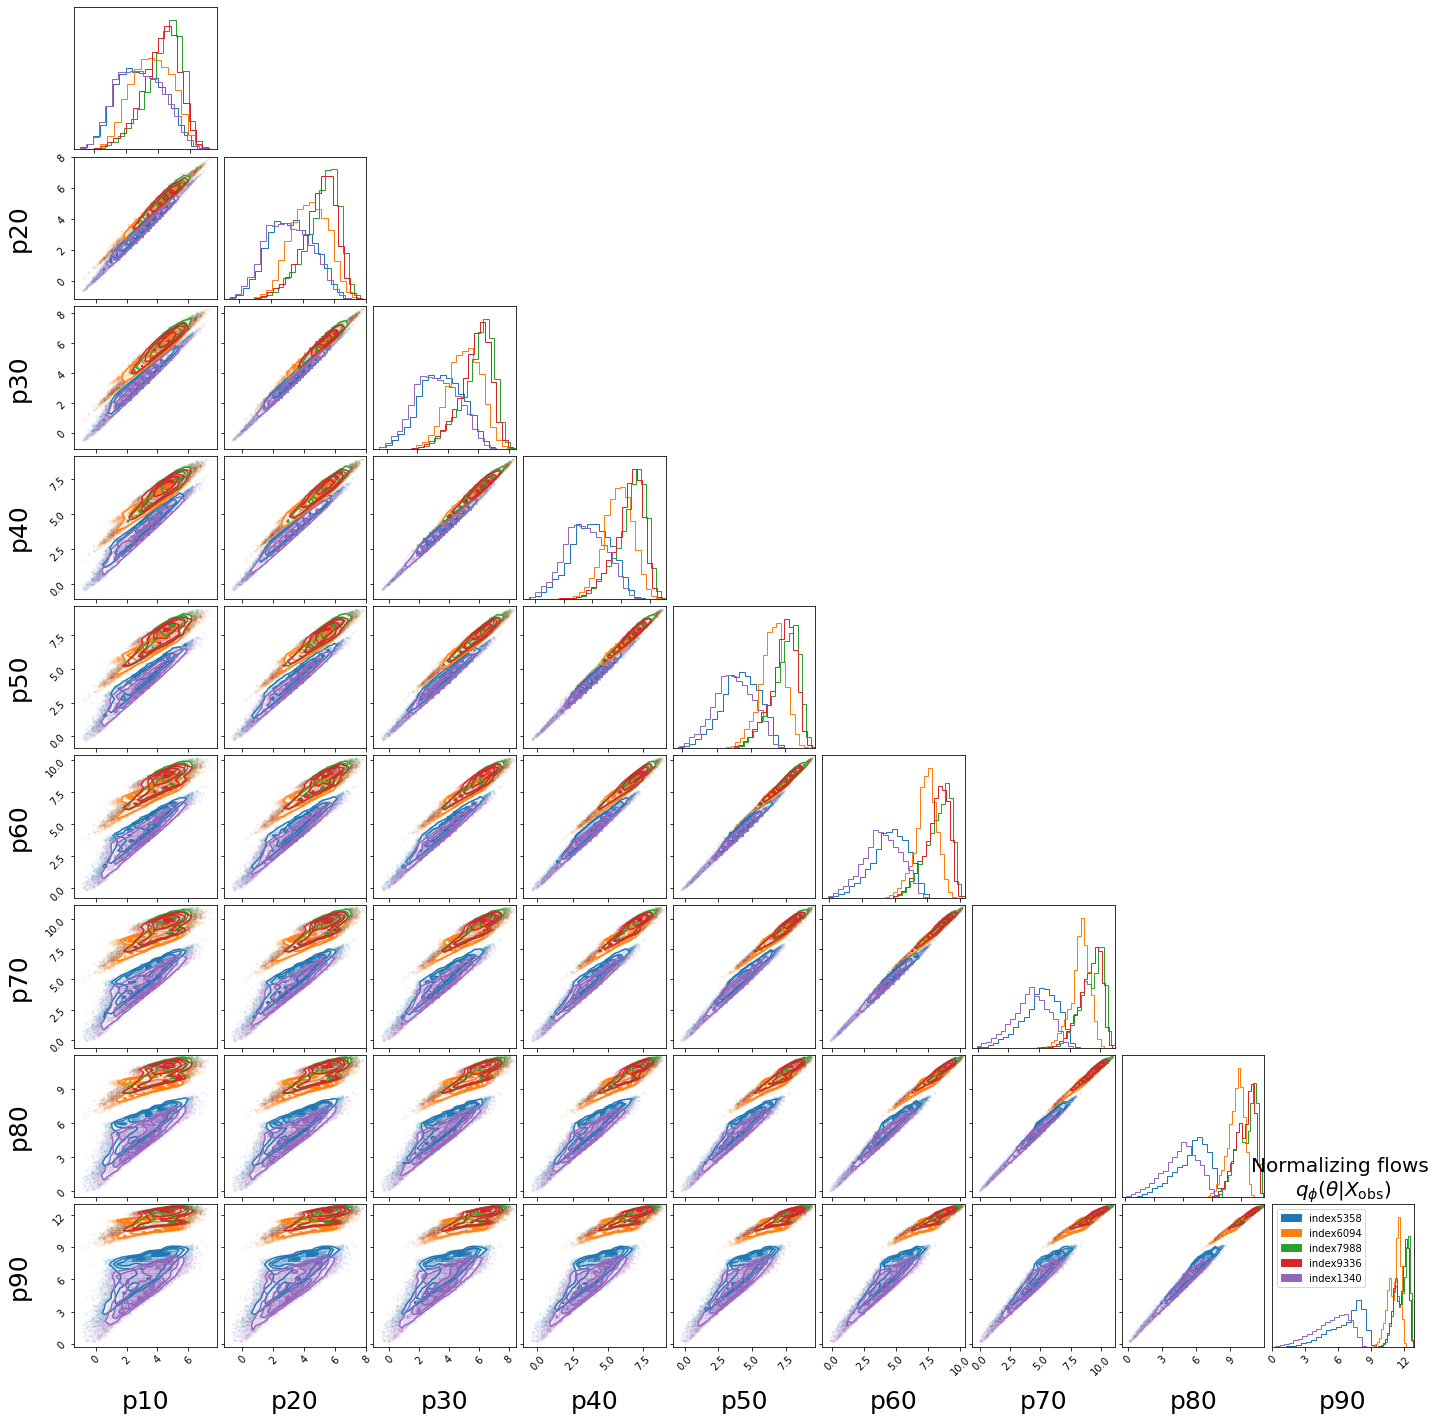

In [87]:
#all percentiles together

best_list=[9925 9631 9062 9359 9819]
#best_list=np.random.randint(9000,10000,5)

fig=plt.figure(figsize=(20,20))

posteriors=[]

for k,j in tqdm(enumerate(best_list)):
    print('index: ',index_sh[j])
    Xobs=latents[index_sh[j],:]
    posterior_samples = np.array(qphi.sample((10000,), 
                                    x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), 
                                    show_progress_bars=False).detach().to('cpu'))
    posteriors.append(posterior_samples)
    #qphi sample is the number of datapoints you want in the plot                            
    #print(np.shape(posterior_samples))

    lt=['p'+str(i*10) for i in range(1,10)] #label for percentiles

    #we plot all the percentiles
    _ = corner.corner(posterior_samples[:,:], 
                      labels=lt,
                      label_kwargs={'fontsize': 25},
                      color='C'+str(k), hist_kwargs={'density': True},fig=fig)
    plt.fill_between([], [], [], color='C'+str(k), label="index"+str(index_sh[j]))
    
plt.legend(loc='upper left', fontsize=10)
plt.title('Normalizing flows \n'+ r'$q_\phi(\theta|X_{\rm obs})$',fontsize=20)
plt.show()

In [89]:
fig.savefig('corner_full.jpg')

[9925 9631 9062 9359 9819]


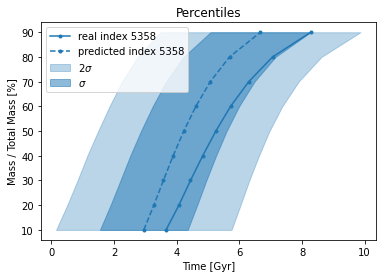

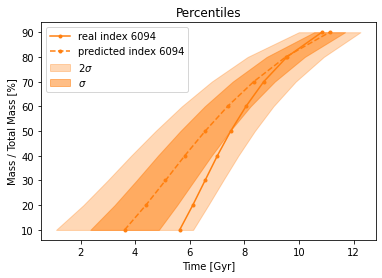

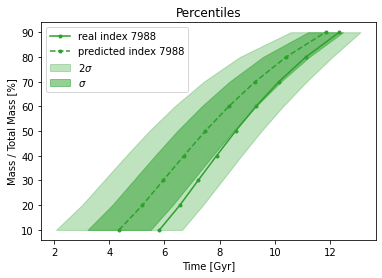

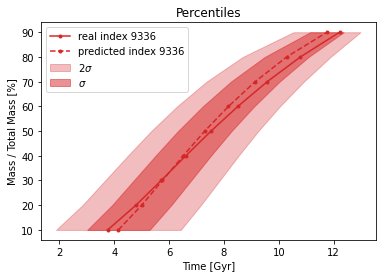

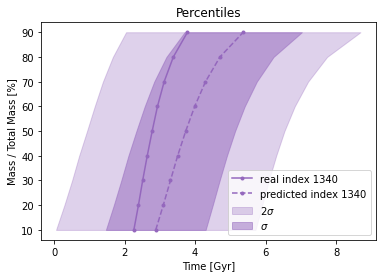

In [90]:
print(best_list)
for k,j in enumerate(best_list): 
                posterior_samples=posteriors[k]
                plt.plot(percentiles[index_sh[j],:],np.arange(10,100,10),'.-',color='C'+str(k),label='real index '+str(index_sh[j]))
                plt.plot(np.mean(posterior_samples,axis=0),np.arange(10,100,10),'.--',color='C'+str(k),label='predicted index '+str(index_sh[j]))
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+2*np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-2*np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.3,label='$2\\sigma$')
                plt.fill_betweenx(np.arange(10,100,10),np.mean(posterior_samples,axis=0)+np.std(posterior_samples[:,:],axis=0),np.mean(posterior_samples,axis=0)-np.std(posterior_samples[:,:],axis=0),color='C'+str(k),alpha=0.5,label='$\\sigma$')
                plt.title('Percentiles')
                plt.xlabel('Time [Gyr]')
                plt.ylabel('Mass / Total Mass [%]')
                plt.legend()
                plt.savefig('corner'+str(k)+'.jpg')
                plt.show()

Quick evaluation of the actual model.  Mean posterior vs truth for all the test set.

In [14]:
n_evaluations=1000
n_samples=1000
index_list=np.arange(9000,10000)

#stds=[]
#means=[]
medians=[]
for k,j in tqdm(enumerate(index_list)):
    Xobs=latents[index_sh[j],:]+np.ones(16)*0.1*np.random.normal(0.0, 0.1)
    posterior_samples= np.array(qphi.sample((n_samples,), x=torch.as_tensor(np.array([Xobs]).astype(np.float32)).to('cpu'), show_progress_bars=False).detach().to('cpu'))
    #stds.append(np.std(posterior_samples,axis=0))
    #means.append(np.mean(posterior_samples,axis=0))
    medians.append(np.median(posterior_samples,axis=0))

1000it [06:53,  2.42it/s]


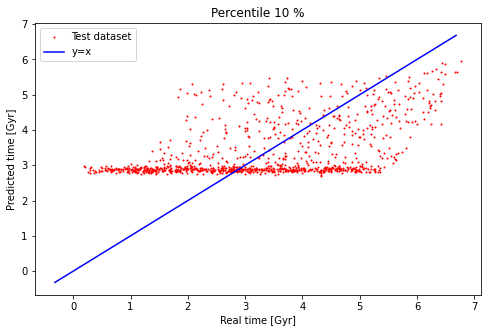

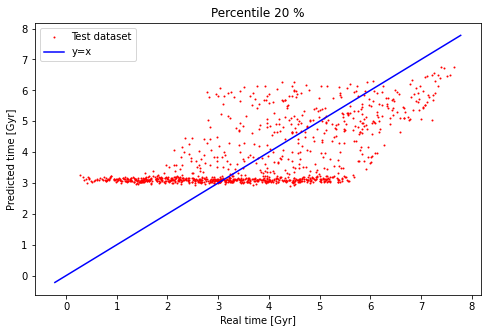

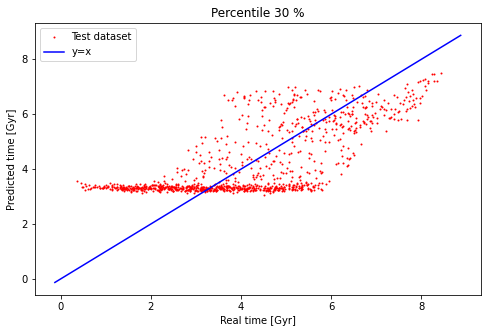

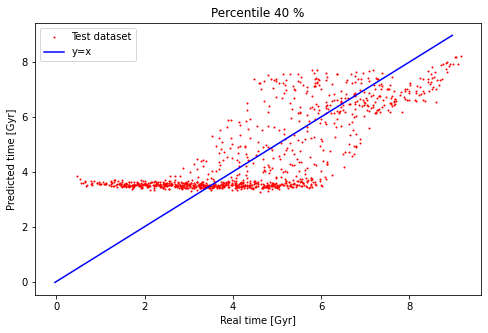

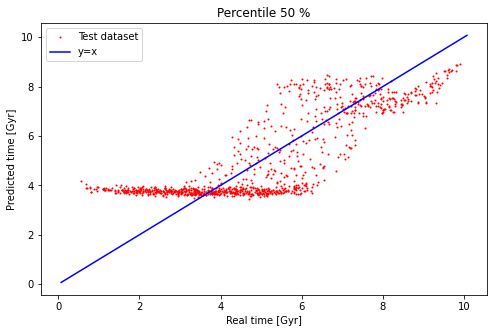

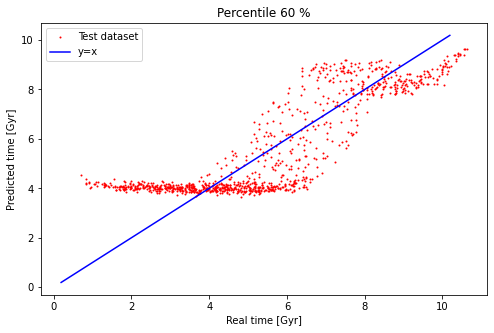

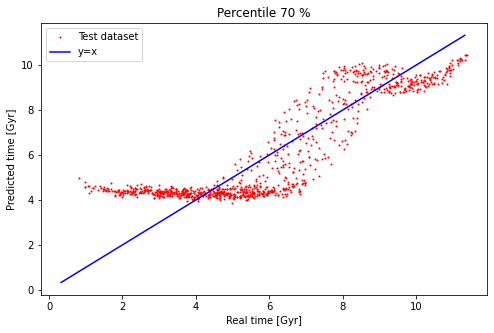

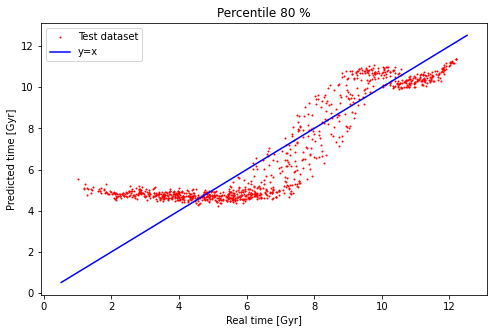

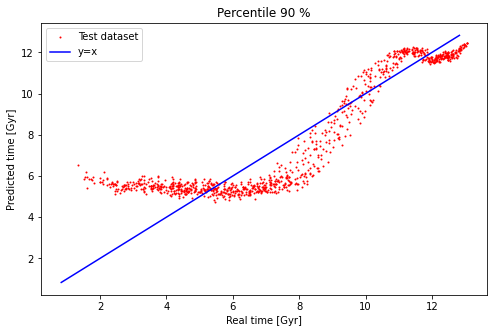

In [26]:
#np.save('means.npy',means)
#means=np.array(means)

for i in range(9):
    p=percentiles[index_sh[index_list],i]
    x=np.arange(np.min(p)-0.5,np.max(p)+0.5)
    plt.figure(figsize=(8,5))
    plt.scatter(p,means[:,i],s=1,color='r',label='Test dataset')
    plt.plot(x,x,label='y=x',color='b')
    plt.xlabel('Real time [Gyr]')
    plt.ylabel('Predicted time [Gyr]')
    plt.legend()
    plt.title('Percentile '+str((i+1)*10)+' %')
    plt.savefig('prediction'+str(i)+'.jpg')
    plt.show()

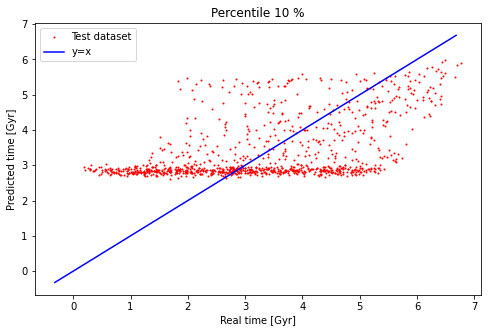

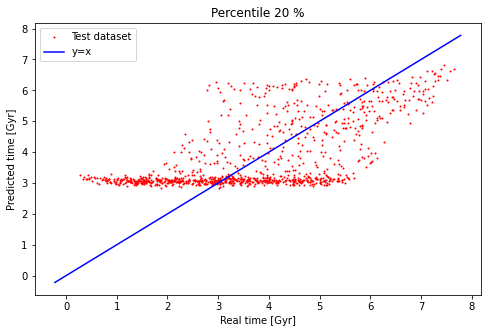

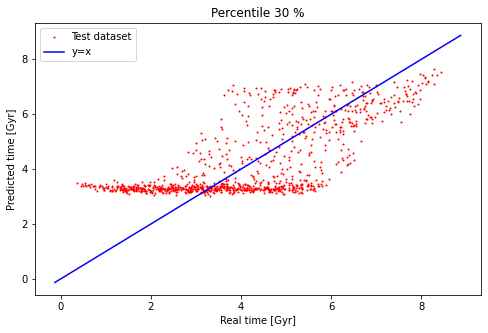

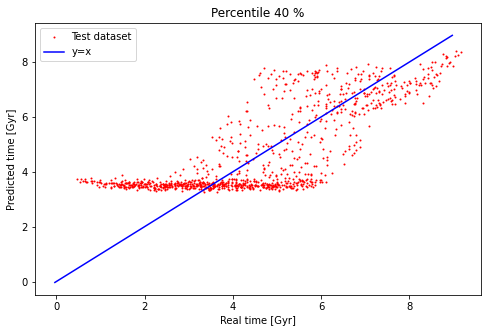

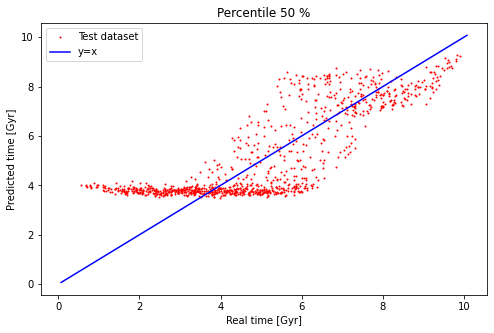

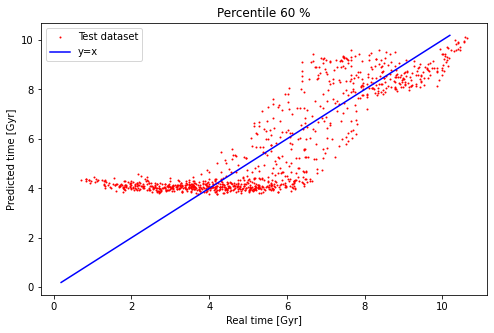

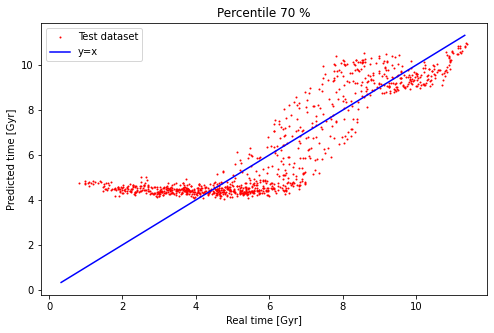

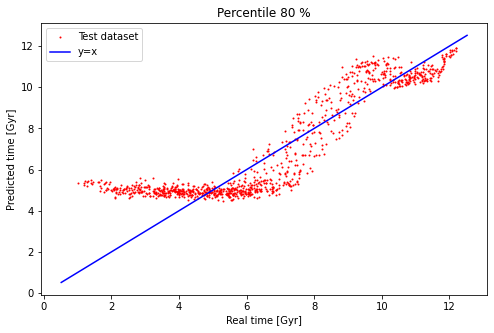

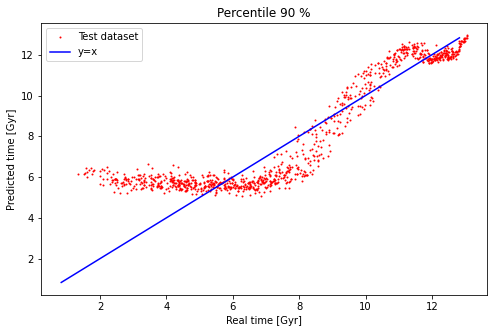

In [27]:
np.save('medians.npy',medians)
medians=np.array(medians)

for i in range(9):
    p=percentiles[index_sh[index_list],i]
    x=np.arange(np.min(p)-0.5,np.max(p)+0.5)
    plt.figure(figsize=(8,5))
    plt.scatter(p,medians[:,i],s=1,color='r',label='Test dataset')
    plt.plot(x,x,label='y=x',color='b')
    plt.xlabel('Real time [Gyr]')
    plt.ylabel('Predicted time [Gyr]')
    plt.legend()
    plt.title('Percentile '+str((i+1)*10)+' %')
    #plt.savefig('prediction'+str(i)+'.jpg')
    plt.show()

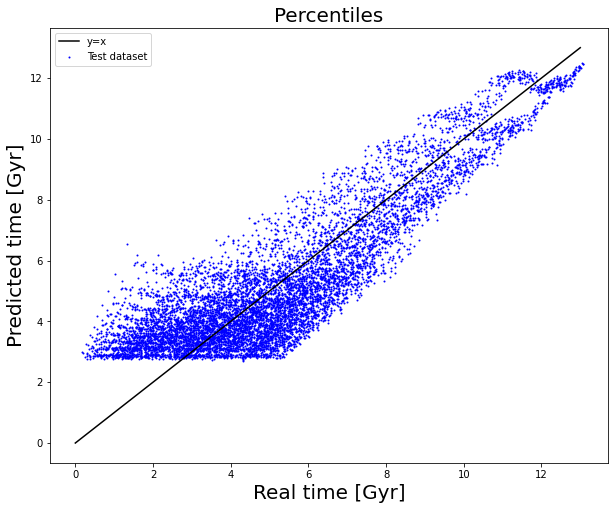

In [24]:
plt.figure(figsize=(10,8))

for i in range(9):
    if i==0:
        plt.plot(np.arange(14),np.arange(14),label='y=x',color='k')
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b',label='Test dataset')#,label=str((i+1)*10)+' %')
    else:
        plt.scatter(percentiles[index_sh[index_list],i],means[:,i],s=1,color='b')#,label=str((i+1)*10)+' %')


        
plt.xlabel('Real time [Gyr]',fontsize=20)
plt.ylabel('Predicted time [Gyr]',fontsize=20)
plt.legend(fontsize=10)
plt.title('Percentiles',fontsize=20)
plt.savefig('pred_vs_true.jpg')
plt.show()